# **Simple Object Detection with MNIST Dataset**

In this notebook, a model based on [Convolutional Neural Networks (CNN)](https://developers.google.com/machine-learning/glossary/#convolutional_neural_network) is implemented for object detection using the [MNIST](https://yann.lecun.com/exdb/mnist/) dataset. The model is trained from scratch and is classified as a simple object detection model, as only one class can be detected per image along with its corresponding bounding box. Additionally, the MNIST dataset is quite simple, consisting of grayscale images and containing only 10 classes (digits from 0 to 9). The dataset includes a total of 70,000 images, of which 60,000 are used for training and 10,000 for testing. Since the dataset does not include bounding boxes for the digits, an artificial variation has been created where each original 28x28 pixel image containing a digit is placed randomly on a black 112x112 pixel canvas, allowing for the creation of the bounding boxes.

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score
import numpy as np
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from google.colab import drive

## **Parameters**

In [ ]:
drive.mount("/content/drive/")

Mounted at /content/drive/


In [ ]:
epochs = 50
batch_size = 128
buffer_size = 1024
AUTOTUNE = tf.data.AUTOTUNE
SEED = 123

## **Load and Preprocess the Dataset**

In [ ]:
(train_dataset, test_dataset), info = tfds.load("mnist", split=["train", "test"], as_supervised=True, with_info=True)
info

tfds.core.DatasetInfo(
    name='mnist',
    full_name='mnist/3.0.1',
    description="""
    The MNIST database of handwritten digits.
    """,
    homepage='http://yann.lecun.com/exdb/mnist/',
    data_dir='/root/tensorflow_datasets/mnist/3.0.1',
    file_format=tfrecord,
    download_size=11.06 MiB,
    dataset_size=21.00 MiB,
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=10),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=10000, num_shards=1>,
        'train': <SplitInfo num_examples=60000, num_shards=1>,
    },
    citation="""@article{lecun2010mnist,
      title={MNIST handwritten digit database},
      author={LeCun, Yann and Cortes, Corinna and Burges, CJ},
      journal={ATT Labs [Online]. Available: http://yann.lecun.com/exdb/mnist},
      volume={2},
      year={2010}
    }""",
)

In [ ]:
num_classes = info.features["label"].num_classes
num_classes

10

In [ ]:
original_size = info.features["image"].shape
new_size = (112, 112, 1)

original_size, new_size

((28, 28, 1), (112, 112, 1))

In [ ]:
# Function to preprocess the images and generate random bounding boxes
def preprocessing(image, label, new_size=new_size):
  size = image.shape

  xmin = tf.random.uniform((), 0, new_size[1] - size[1] + 1, dtype=tf.int32)
  ymin = tf.random.uniform((), 0, new_size[0] - size[0] + 1, dtype=tf.int32)
  xmax = xmin + size[1]
  ymax = ymin + size[0]

  image = tf.image.pad_to_bounding_box(image, ymin, xmin, new_size[0], new_size[1])
  image = image / 255

  xmin, xmax = xmin/new_size[1], xmax/new_size[1]
  ymin, ymax = ymin/new_size[0], ymax/new_size[0]
  box = tf.stack([xmin, ymin, xmax, ymax])

  return image, (label, box)

In [ ]:
train_dataset = (
    train_dataset.
    map(preprocessing, num_parallel_calls=AUTOTUNE).
    shuffle(buffer_size, seed=SEED).
    batch(batch_size).
    prefetch(AUTOTUNE)
)

test_dataset = (
    test_dataset.
    map(preprocessing, num_parallel_calls=AUTOTUNE).
    batch(batch_size).
    prefetch(AUTOTUNE)
)

In [ ]:
# Take a batch from the training dataset
for images, (labels, boxes) in train_dataset.take(1):
  print(images.shape)
  print(labels.shape)
  print(boxes.shape)

(128, 112, 112, 1)
(128,)
(128, 4)


**Function to display images along with their corresponding bounding boxes**

Bounding boxes can be plotted using the OpenCV library; however, it only allows coordinates of type ``int``, which can result in a loss of precision when drawing the bounding boxes. Therefore, in this case, Matplotlib is used, as it accepts ``float`` coordinates, providing greater accuracy.

In [ ]:
def show_images(images, labels, boxes, labels_pred=None, boxes_pred=None, num_examples=9,
                random=True, cmap="gray", axis="off", save=False, path=""):

  n = int(np.sqrt(num_examples))
  indices = np.arange(len(images))
  if random:
    np.random.shuffle(indices)

  fig, axes = plt.subplots(n, n, figsize=(2.5*n, 2.5*n))

  for i, ax in enumerate(axes.flat):
    image = images[indices[i]]
    label = labels[indices[i]]

    box = boxes[indices[i]]
    xmin, ymin, xmax, ymax = tuple(box)
    xmin, xmax = xmin*new_size[1], xmax*new_size[1]
    ymin, ymax = ymin*new_size[0], ymax*new_size[0]

    ax.imshow(image, cmap=cmap)
    rect = patches.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, linewidth=1.2, edgecolor="mediumblue", facecolor="none")
    ax.add_patch(rect)

    if (labels_pred is not None) and (boxes_pred is not None):
      label_pred = labels_pred[indices[i]]

      box_pred = boxes_pred[indices[i]]
      xmin_pred, ymin_pred, xmax_pred, ymax_pred = tuple(box_pred)
      xmin_pred, xmax_pred = xmin_pred*new_size[1], xmax_pred*new_size[1]
      ymin_pred, ymax_pred = ymin_pred*new_size[0], ymax_pred*new_size[0]

      rect_pred = patches.Rectangle(
          (xmin_pred, ymin_pred), xmax_pred-xmin_pred, ymax_pred-ymin_pred,
          linewidth=1.2, edgecolor="red", facecolor="none"
      )
      ax.add_patch(rect_pred)

      ax.text(
          x=0, y=1, s=f"Label: {label}", color="mediumblue", fontsize=8,
          fontweight="bold", ha="left", va="bottom", transform=ax.transAxes
      )
      ax.text(
          x=1, y=1, s=f"Pred: {label_pred}", color="red", fontsize=8,
          fontweight="bold", ha="right", va="bottom", transform=ax.transAxes
      )
      ax.text(
          x=0.5, y=-0.01, s=f"IoU: {calculate_giou(box, box_pred).numpy():.2f}",
          fontsize=7, fontweight="bold", ha="center", va="top", transform=ax.transAxes
      )

    else:
      ax.text(
          x=0.5, y=1, s=f"Label: {label}", fontsize=8,
          fontweight="bold", ha="center", va="bottom", transform=ax.transAxes
      )

    ax.axis(axis)

  plt.tight_layout()
  # Save images
  if save:
    plt.savefig(path)

  plt.show()

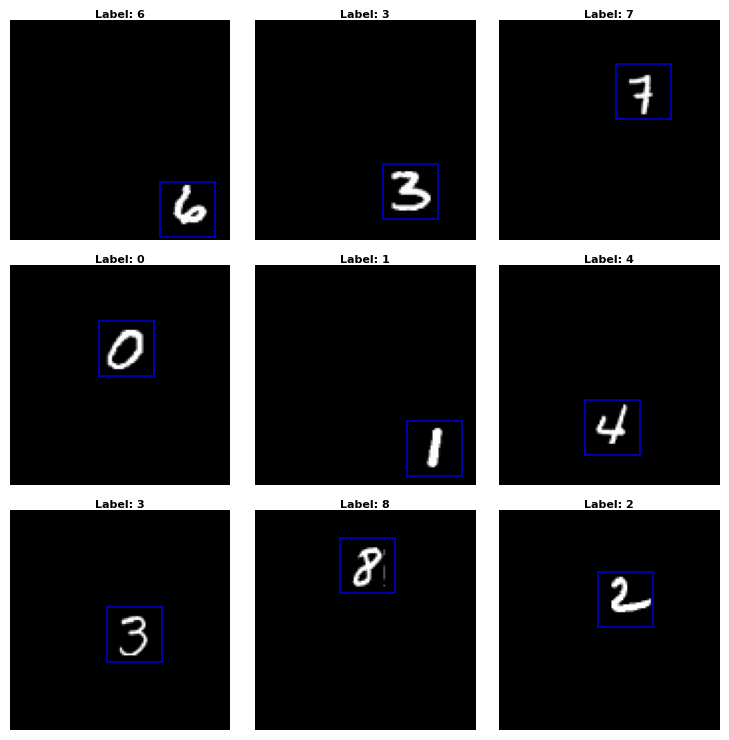

In [ ]:
# Some images from the training dataset
show_images(images, labels, boxes, random=False)

## **Model Building**

In [ ]:
def build_model(input_shape=new_size):
  inputs = tf.keras.layers.Input(shape=input_shape)

  x = tf.keras.layers.Conv2D(16, kernel_size=3, padding="same", activation="relu")(inputs)
  x = tf.keras.layers.MaxPooling2D(pool_size=2)(x)
  x = tf.keras.layers.Conv2D(32, kernel_size=3, padding="same", activation="relu")(x)
  x = tf.keras.layers.MaxPooling2D(pool_size=2)(x)
  x = tf.keras.layers.Conv2D(64, kernel_size=3, padding="same", activation="relu")(x)
  x = tf.keras.layers.MaxPooling2D(pool_size=2)(x)
  x = tf.keras.layers.Conv2D(128, kernel_size=3, padding="same", activation="relu")(x)
  x = tf.keras.layers.MaxPooling2D(pool_size=2)(x)
  x = tf.keras.layers.Flatten()(x)
  x = tf.keras.layers.Dense(128, activation="relu")(x)

  classifier = tf.keras.layers.Dense(num_classes, activation="softmax", name="classifier")(x)
  box_regressor = tf.keras.layers.Dense(4, activation="sigmoid", name="box_regressor")(x)

  model = tf.keras.Model(inputs=inputs, outputs=[classifier, box_regressor])
  return model

In [ ]:
tf.keras.backend.clear_session()

model = build_model(new_size)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 112, 112, 1)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 112, 112, 16)   │            160 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 56, 56, 16)     │              0 │ conv2d[0][0]           │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 56, 56, 32)     │          4,640 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 28, 28, 32)     │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 28, 28, 64)     │         18,496 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 14, 14, 64)     │              0 │ conv2d_2[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 14, 14, 128)    │         73,856 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_3           │ (None, 7, 7, 128)      │              0 │ conv2d_3[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten (Flatten)         │ (None, 6272)           │              0 │ max_pooling2d_3[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 128)            │        802,944 │ flatten[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ classifier (Dense)        │ (None, 10)             │          1,290 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ box_regressor (Dense)     │ (None, 4)              │            516 │ dense[0][0]            │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 901,902 (3.44 MB)

 Trainable params: 901,902 (3.44 MB)

 Non-trainable params: 0 (0.00 B)

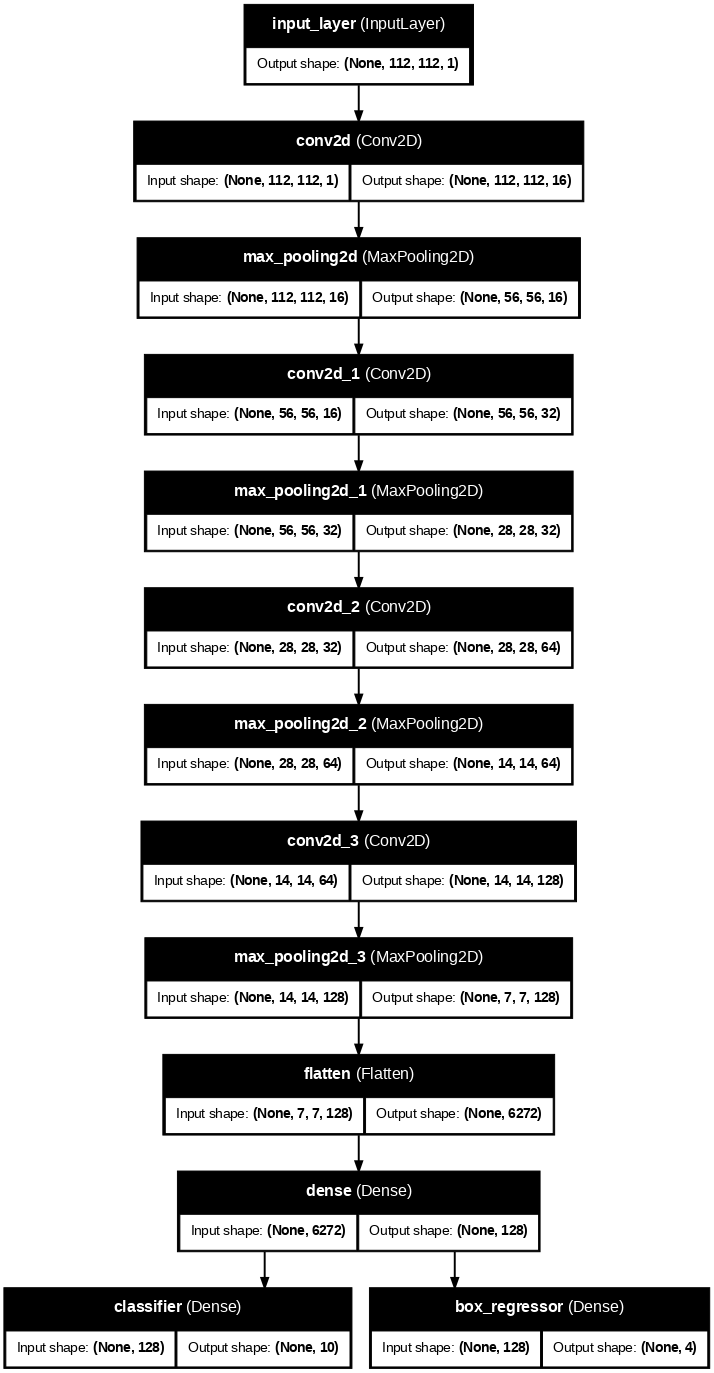

In [ ]:
# Visualizing the architecture of the model
tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=True, dpi=70)

## **Model Compilation**

In object detection, better results can be achieved by combining the standard loss for **bounding boxes** (Mean Squared Error or **MSE**) with the **GIoU** loss (Generalized Intersection over Union). GIoU is an improvement over the **IoU** (Intersection over Union) metric, which measures the overlap between the predicted and ground truth bounding boxes. While IoU only considers the common area between the two boxes, GIoU introduces an additional term that penalizes the lack of overlap, even when the boxes do not intersect. This helps improve model convergence, especially in scenarios where the predicted boxes are misaligned or fall outside the area of interest. For more details, see the following [article](https://giou.stanford.edu/GIoU.pdf).

The model's performance in predicting bounding boxes is better assessed using the IoU metric, which is calculated as the ratio of the intersection area to the union area of two boxes. Conventional accuracy is not suitable for this task. The IoU value ranges from 0 to 1, with 1 indicating a perfect match.

Below, both the **IoU** metric and **GIoU** loss are implemented using TensorFlow to improve results:

In [ ]:
# Function to calculate IoU and GIoU given the coordinates of two Bounding Boxes
@tf.function
def calculate_giou(box_true, box_pred, metric="iou"):

  # Convert the box coordinates to float32
  box_true = tf.cast(box_true, tf.float32)
  box_pred = tf.cast(box_pred, tf.float32)

  # Extract the minimum and maximum coordinates of the boxes
  xmin_true, ymin_true, xmax_true, ymax_true = tf.unstack(box_true, axis=-1)
  xmin_pred, ymin_pred, xmax_pred, ymax_pred = tf.unstack(box_pred, axis=-1)

  # Calculate the areas of the true and predicted boxes
  width_true = tf.maximum(xmax_true - xmin_true, 0)
  height_true = tf.maximum(ymax_true - ymin_true, 0)
  width_pred = tf.maximum(xmax_pred - xmin_pred, 0)
  height_pred = tf.maximum(ymax_pred - ymin_pred, 0)
  area_true = width_true * height_true
  area_pred = width_pred * height_pred

  # Calculate the intersection area
  intersect_xmin = tf.maximum(xmin_true, xmin_pred)
  intersect_ymin = tf.maximum(ymin_true, ymin_pred)
  intersect_xmax = tf.minimum(xmax_true, xmax_pred)
  intersect_ymax = tf.minimum(ymax_true, ymax_pred)
  intersect_width = tf.maximum(intersect_xmax - intersect_xmin, 0)
  intersect_height = tf.maximum(intersect_ymax - intersect_ymin, 0)
  intersect_area = intersect_width * intersect_height

  # Calculate the union area
  union_area = area_true + area_pred - intersect_area

  # Calculate IoU
  iou = tf.math.divide_no_nan(intersect_area, union_area)

  # Return IoU if required
  if metric == "iou":
    return iou

  # Calculate the area of the minimum enclosing box
  enclose_xmin = tf.minimum(xmin_true, xmin_pred)
  enclose_ymin = tf.minimum(ymin_true, ymin_pred)
  enclose_xmax = tf.maximum(xmax_true, xmax_pred)
  enclose_ymax = tf.maximum(ymax_true, ymax_pred)
  enclose_width = tf.maximum(enclose_xmax - enclose_xmin, 0)
  enclose_height = tf.maximum(enclose_ymax - enclose_ymin, 0)
  enclose_area = enclose_width * enclose_height

  # Calculate GIoU
  giou = iou - tf.math.divide_no_nan(enclose_area - union_area, enclose_area)
  return giou

In [ ]:
# Custom metric to calculate IoU
@tf.keras.utils.register_keras_serializable()
def metric_iou(box_true, box_pred):
  return tf.reduce_mean(calculate_giou(box_true, box_pred))


# Custom loss that combines MSE and GIoU for the bounding boxes
@tf.keras.utils.register_keras_serializable()
def custom_loss(box_true, box_pred):
  loss_mse = tf.keras.losses.MeanSquaredError()(box_true, box_pred)
  loss_giou = 1 - calculate_giou(box_true, box_pred, metric="giou")
  loss_giou = tf.reduce_mean(loss_giou)

  loss = 5*loss_mse + 2*loss_giou
  return loss

The total loss of the model is given by the following formula:

**$$ \text{TotalLoss} = 1 \times \text{SparseCategoricalCrossentropy} + 2 \times \text{GIoULoss} + 5 \times \text{MeanSquaredError} $$**


In [ ]:
model.compile(
    optimizer="adam",
    loss={"classifier": "sparse_categorical_crossentropy", "box_regressor": custom_loss},
    loss_weights={"classifier": 1.0, "box_regressor": 1.0},
    metrics = {"classifier": "accuracy", "box_regressor": metric_iou}
)

## **Train the Model**

In [ ]:
# Custom callback that uses two monitors to stop training
class CustomEarlyStopping(tf.keras.callbacks.Callback):
  def __init__(self, monitor_1, monitor_2, patience=0, restore_best_weights=False):
    super().__init__()
    self.monitor_1 = monitor_1
    self.monitor_2 = monitor_2
    self.patience = patience
    self.restore_best_weights = restore_best_weights
    self.best = {monitor_1: -float("inf"), monitor_2: -float("inf")}
    self.wait = 0
    self.stopped_epoch = 0
    self.best_weights = None

  def on_train_begin(self, logs=None):
    if self.restore_best_weights:
      self.best_weights = self.model.get_weights()

  def on_epoch_end(self, epoch, logs=None):
    logs = logs or {}
    current_1 = logs.get(self.monitor_1)
    current_2 = logs.get(self.monitor_2)

    if current_1 is None or current_2 is None:
      return

    if (current_1 > self.best[self.monitor_1]) and (current_2 > self.best[self.monitor_2]):
        self.best[self.monitor_1] = current_1
        self.best[self.monitor_2] = current_2
        self.wait = 0
        if self.restore_best_weights:
          self.best_weights = self.model.get_weights()
    else:
      self.wait += 1

    if self.wait >= self.patience:
      self.stopped_epoch = epoch
      self.model.stop_training = True
      if self.restore_best_weights:
        self.model.set_weights(self.best_weights)

In [ ]:
# Callback to stop training if validation accuracy and IoU don't improve for 3 epochs
patience = 3
callback = CustomEarlyStopping(
    monitor_1="val_classifier_accuracy",
    monitor_2="val_box_regressor_metric_iou",
    patience=patience,
    restore_best_weights=True
)

In [ ]:
history = model.fit(train_dataset, epochs=epochs, validation_data=test_dataset, callbacks=[callback])

Epoch 1/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 43s 76ms/step - box_regressor_metric_iou: 0.7062 - classifier_accuracy: 0.1845 - loss: 2.8072 - val_box_regressor_metric_iou: 0.8323 - val_classifier_accuracy: 0.8147 - val_loss: 1.0483
Epoch 2/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 20s 42ms/step - box_regressor_metric_iou: 0.8418 - classifier_accuracy: 0.8791 - loss: 0.7866 - val_box_regressor_metric_iou: 0.8719 - val_classifier_accuracy: 0.9601 - val_loss: 0.4164
Epoch 3/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 20s 41ms/step - box_regressor_metric_iou: 0.8829 - classifier_accuracy: 0.9601 - loss: 0.3917 - val_box_regressor_metric_iou: 0.9048 - val_classifier_accuracy: 0.9758 - val_loss: 0.2857
Epoch 4/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 19s 39ms/step - box_regressor_metric_iou: 0.9039 - classifier_accuracy: 0.9724 - loss: 0.3005 - val_box_regressor_metric_iou: 0.9021 - val_classifier_accuracy: 0.9830 - val_loss: 0.2658
Epoch 5/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 22s 42ms/step - box_regressor_metric_iou: 0.9134 - class

**Save the model**

In [ ]:
trained_model_path = "/content/drive/MyDrive/models/SimpleObjectDetection_CNN_MNIST.keras"
model.save(trained_model_path)

## **Model Evaluation**

In [ ]:
metrics_train = model.evaluate(train_dataset, verbose=0)
metrics_test = model.evaluate(test_dataset, verbose=0)

print(f"Train\tLoss: {metrics_train[0]}; IoU: {metrics_train[1]}; Accuracy: {metrics_train[2]}")
print(f"Test\tLoss: {metrics_test[0]}; IoU: {metrics_test[1]}; Accuracy: {metrics_test[2]}")

Train	Loss: 0.12976057827472687; IoU: 0.947218120098114; Accuracy: 0.9935666918754578
Test	Loss: 0.12872867286205292; IoU: 0.9471876621246338; Accuracy: 0.9929999709129333


The evaluation results may differ slightly from those in the training history because the bounding boxes in each batch are generated randomly, even in the test dataset.

### **Graphs of the metrics**

In [ ]:
# Library needed to convert Plotly interactive graphics into images
!pip install kaleido -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 10.7 MB/s eta 0:00:00


In [ ]:
# Function to plot the metrics
def plot_metrics(history=history.history, renderer=None, with_patience=True):
  epochs = len(history["loss"])
  list_epochs = np.arange(1, epochs+1)
  metrics = list(history.keys())
  num_metrics = len(metrics) // 2

  for metric in metrics[:num_metrics]:
    values = history[metric]
    val_values = history[f"val_{metric}"]
    metric = "IoU" if "iou" in metric else metric.split("_")[-1].capitalize()

    fig=go.Figure()
    fig.add_trace(go.Scatter(x=list_epochs, y=values, name=metric, line=dict(color="blue", width=2)))
    fig.add_trace(go.Scatter(x=list_epochs, y=val_values, name=f"Val {metric}", line=dict(color="#FF6600", width=2)))

    if with_patience:
      fig.add_vline(
          x=epochs-patience, line=dict(color="red", width=2, dash="dash"),
          annotation_text="End of Training", annotation_position="top left",
          annotation=dict(font_size=12, font_color="red")
      )

    fig.update_xaxes(title_text="Epoch")
    fig.update_yaxes(title_text=metric)
    fig.update_layout(
        title=f"Evolution of {metric} across Epochs",
        title_font=dict(size=20),
        title_x=0.5,
        height=500,
        width=1200
    )

    fig.show(renderer)

In [ ]:
# Interactive graphic
plot_metrics()

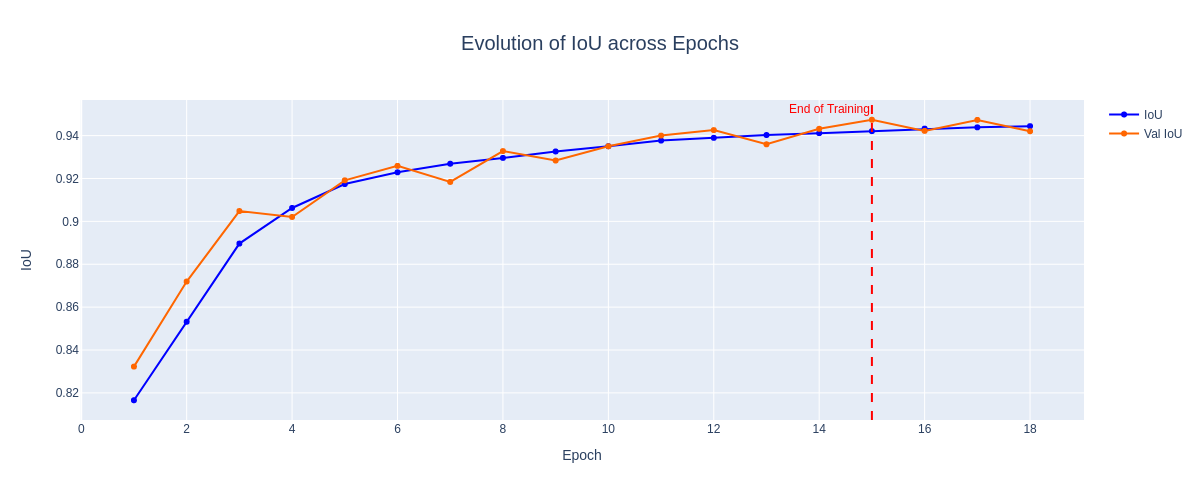

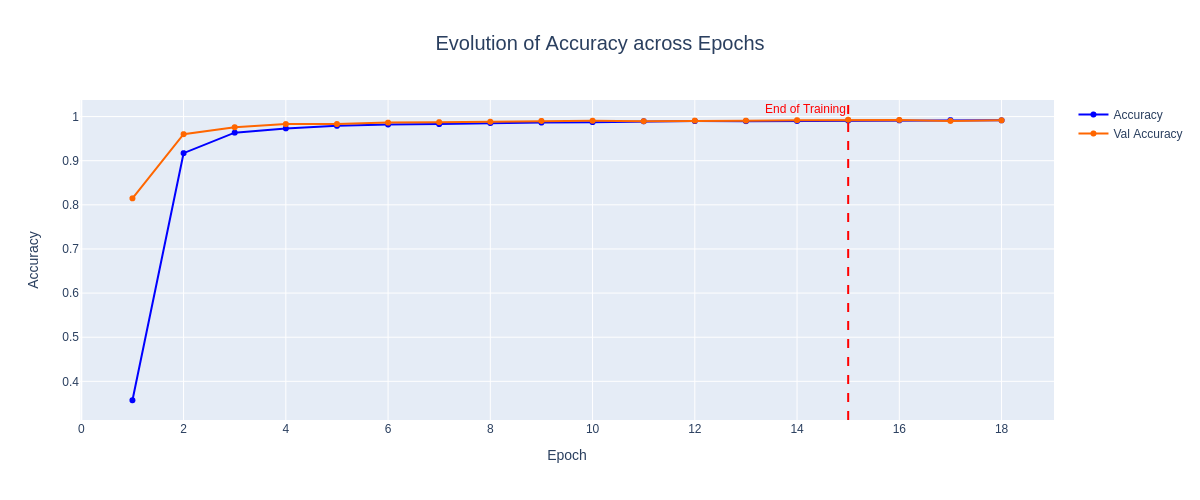

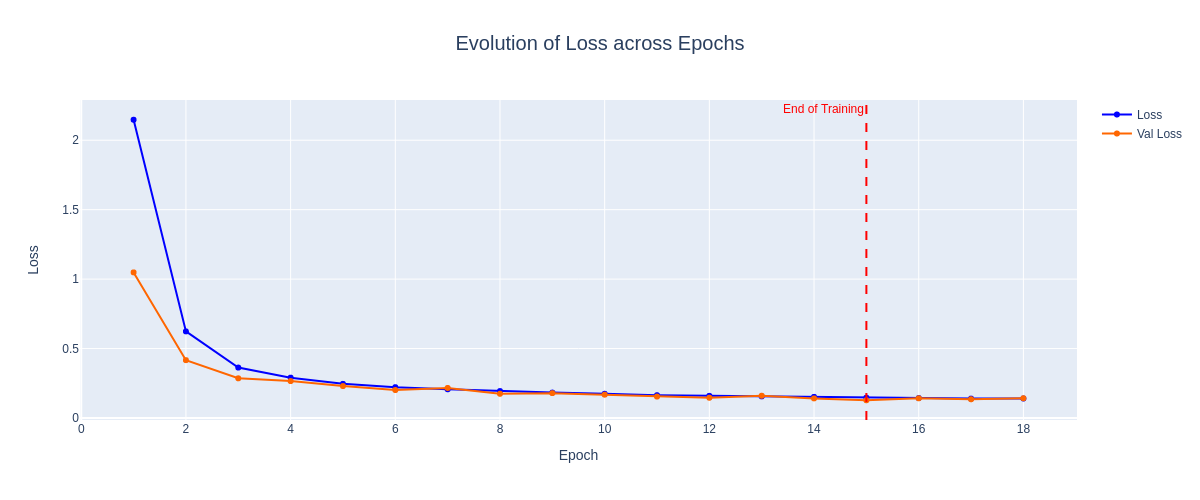

In [ ]:
# Static image for GitHub
plot_metrics(renderer="png")

### **Confusion Matrix**

In [ ]:
# Extract images, labels and boxes from the test dataset
images_test, labels_test, boxes_test = [], [], []

for images, (labels, boxes) in test_dataset.unbatch():
  images_test.append(images.numpy())
  labels_test.append(labels.numpy())
  boxes_test.append(boxes.numpy())

images_test = np.array(images_test)
labels_test = np.array(labels_test)
boxes_test = np.array(boxes_test)

# Generate predictions with the trained model
predictions = model.predict(images_test, batch_size=batch_size)
labels_test_pred = np.argmax(predictions[0], axis=-1)
boxes_test_pred = predictions[1]

# Consolidating the accuracy of the test dataset
print("Accuracy:", np.mean(labels_test == labels_test_pred))
print(f"F1 Score: {f1_score(labels_test, labels_test_pred, average='macro')}")

79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step
Accuracy: 0.993
F1 Score: 0.992948933542581


Frequency per Label: [ 980 1135 1032 1010  982  892  958 1028  974 1009] 



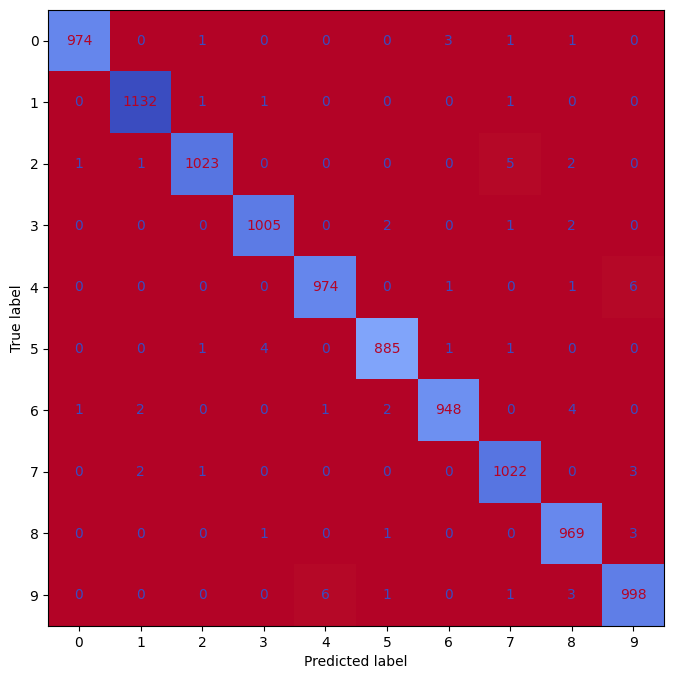

In [ ]:
print("Frequency per Label:", np.unique(labels_test, return_counts=True)[1], "\n")

cm = confusion_matrix(labels_test, labels_test_pred)
cmd = ConfusionMatrixDisplay(cm)
fig, ax = plt.subplots(figsize=(8, 8))
cmd.plot(ax=ax, colorbar=False, cmap="coolwarm_r");

### **IoU Metric**

In [ ]:
iou_test = calculate_giou(boxes_test, boxes_test_pred).numpy()

print("Mean IoU:", iou_test.mean())
print("Min IoU:", iou_test.min())
print("Max IoU:", iou_test.max())
print(f"Percentage of detections with IoU >= 0.5: {np.mean(iou_test >= 0.5) * 100:.2f}%")
print(f"Percentage of detections with IoU >= 0.75: {np.mean(iou_test >= 0.75) * 100:.2f}%")
print(f"Percentage of detections with IoU >= 0.9: {np.mean(iou_test >= 0.9) * 100:.2f}%")

Mean IoU: 0.9477143
Min IoU: 0.8250274
Max IoU: 0.9977524
Percentage of detections with IoU >= 0.5: 100.00%
Percentage of detections with IoU >= 0.75: 100.00%
Percentage of detections with IoU >= 0.9: 96.50%


## **Predictions on the Test Dataset**

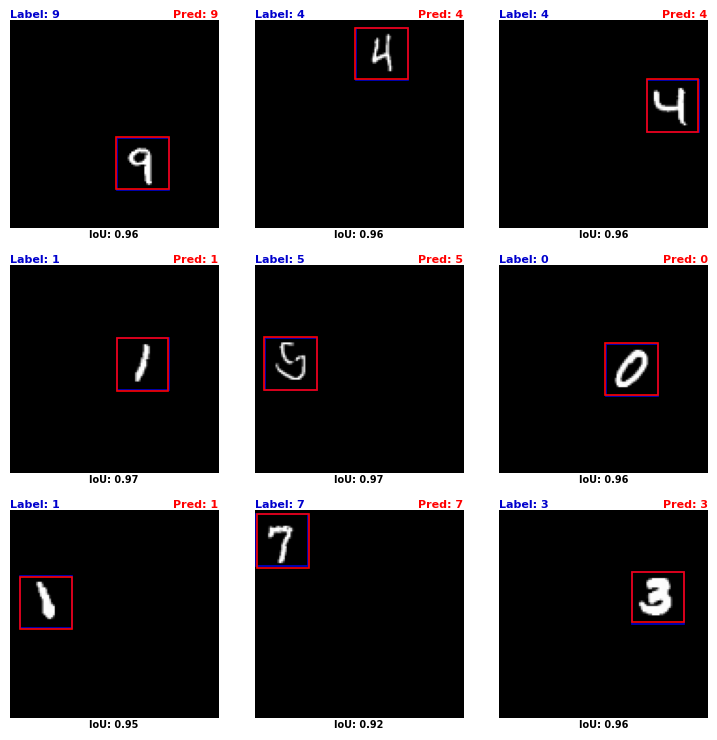

In [ ]:
show_images(images_test, labels_test, boxes_test, labels_test_pred, boxes_test_pred)

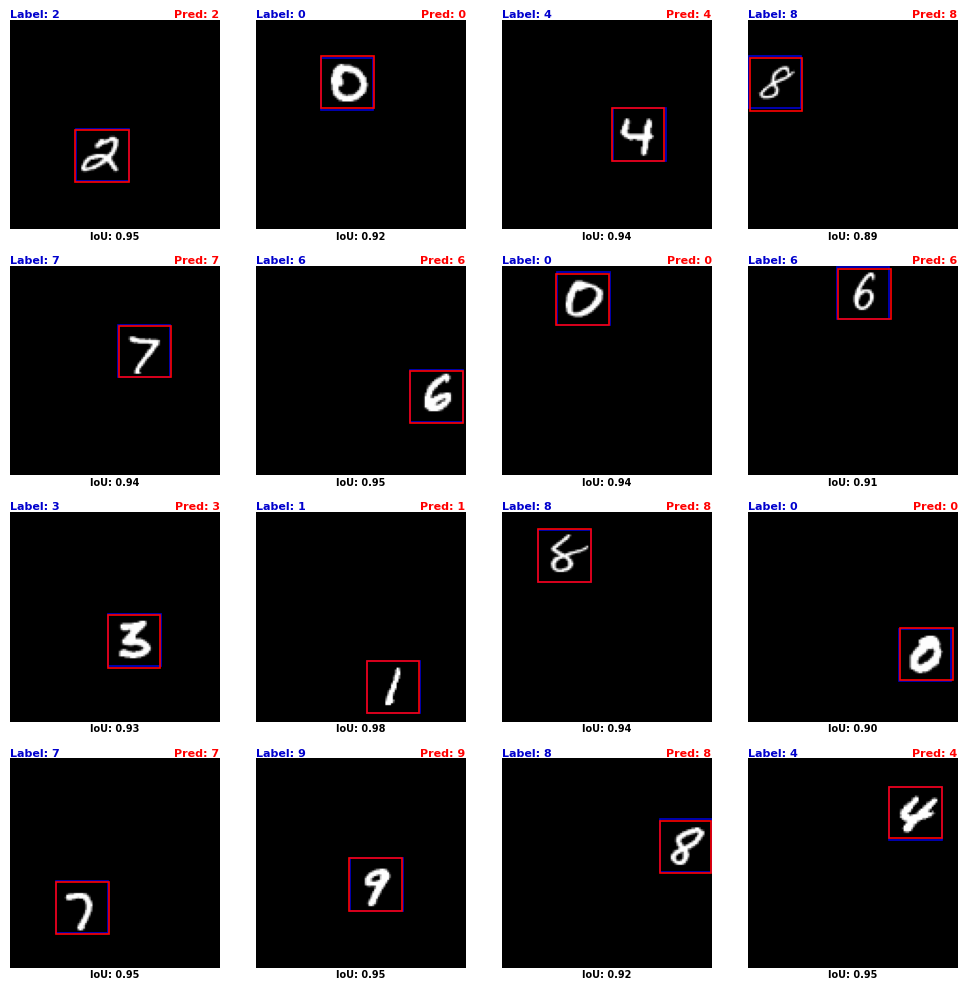

In [ ]:
show_images(
    images_test, labels_test, boxes_test, labels_test_pred, boxes_test_pred,
    num_examples=16, random=False
)

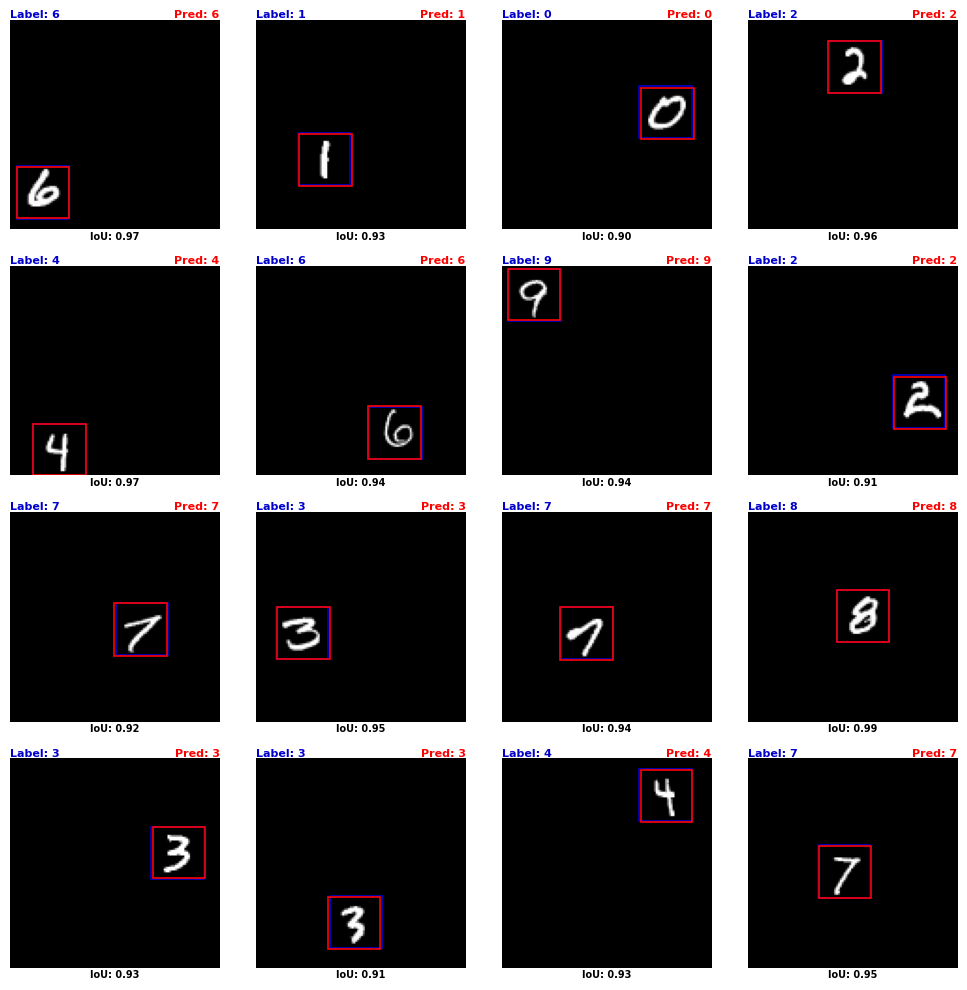

In [ ]:
show_images(
    images_test, labels_test, boxes_test, labels_test_pred, boxes_test_pred,
    num_examples=16, save=True, path="SimpleObjectDetection_CNN_MNIST.png"
)

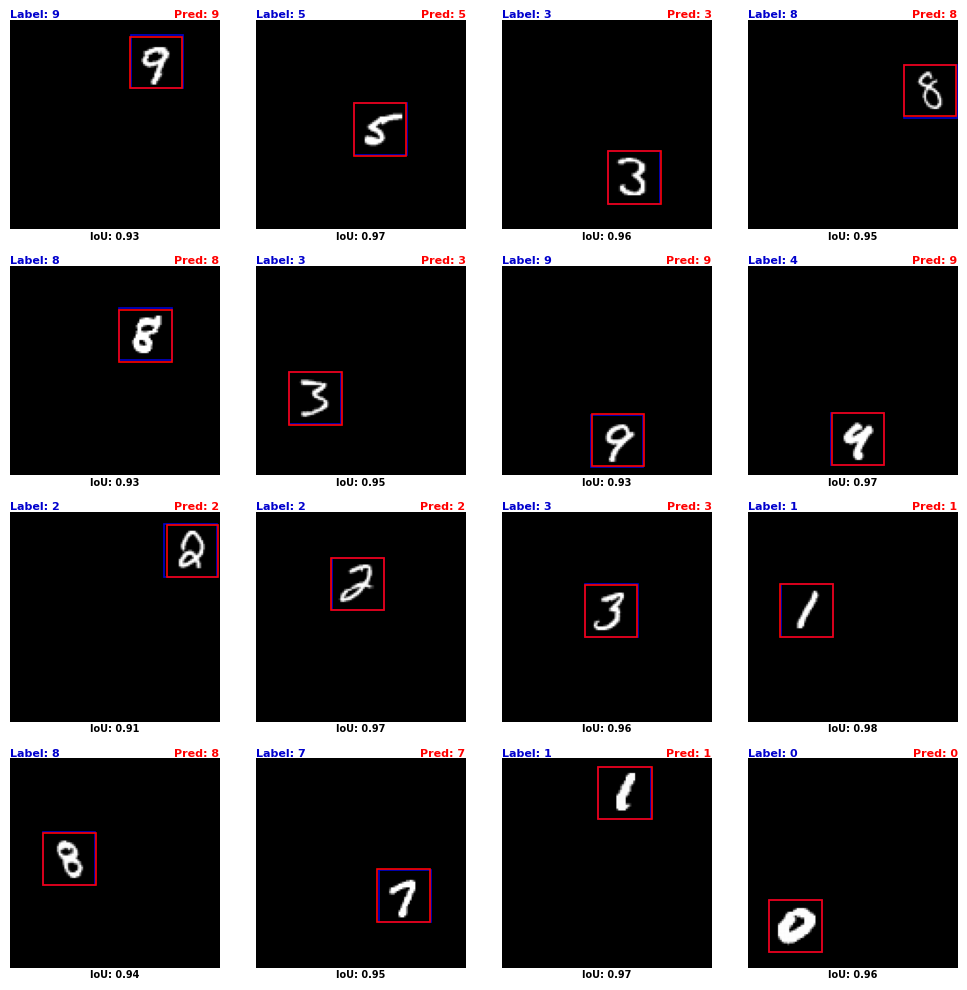

In [ ]:
# This image shows an incorrect classifier prediction
show_images(
    images_test, labels_test, boxes_test, labels_test_pred, boxes_test_pred,
    num_examples=16
)

**Conclusión:**

The model demonstrates excellent performance, achieving an **accuracy** of **99.36%** and an **average IoU** of **0.9472** on the **training dataset**, and an **accuracy** and **F1 score** of **99.3%** with an **average IoU** of **0.9477** on the **test dataset**. This indicates no overfitting, thanks to the custom callback and effective model implementation, delivering strong results for both the classifier (labels) and the regressor (bounding boxes).

Furthermore, all bounding boxes in the test set have IoU values above 0.75, with a minimum of 0.825, highlighting the effectiveness of combining GIoU loss with MSE. While these results suggest the model is highly effective, achieving this performance in real-world scenarios with more complex datasets is challenging, yet this serves as a solid foundation for more advanced models.

Additionally, the fact that the test accuracy matches the F1 score indicates a good balance between recall and precision. Despite some class imbalance in the test set, with sample sizes ranging from 892 to 1,135, the model achieved balanced classification.